In [99]:
##for a pair of odds where x and y are complements of each other i.e. duke winning vs UNC or UNC winning vs Duke
def odds_to_prob2(x, y):
    if (x < 0):
        prob_x = (-1 * x) / (100 - x)
    else:
        prob_x = 100 / (x + 100)
    if (y < 0):
        prob_y = (-1 * y) / (100 - y)
    else:
        prob_y = 100 / (y + 100)
    vig = prob_x + prob_y - 1.0
    prob_x -= vig/2
    prob_y -= vig/2
    return (prob_x, prob_y)

def vig(x, y):
    if (x < 0):
        prob_x = (-1 * x) / (100 - x)
    else:
        prob_x = 100 / (x + 100)
    if (y < 0):
        prob_y = (-1 * y) / (100 - y)
    else:
        prob_y = 100 / (y + 100)
    vig = prob_x + prob_y - 1.0
    return vig

##Converting 
def odds_to_prob1(odds):
    if (odds < 0):
        return (-1 * odds) / (100 - odds)
    else:
        return 100 / (odds + 100)

##exp value payout for a bet size of $1
def calc_statistical_edge(odds, consensus_prob):
    if (odds < 0):
        payout = ((-100 / odds) + 1)
    else:
        payout = ((odds / 100) + 1)
    return payout * consensus_prob


def exp_value(odds, consensus_prob, principle):
    if (odds < 0):
        payout = ((-100 / odds) + 1) * principle
    else:
        payout = ((odds / 100) + 1) * principle
    return payout * consensus_prob

##If you want the statistical edge, just do the expected value for a principle of $1

def consensus_prob_calc(probs, weights=None):
    if not weights: # fallback value
        weights = [1/len(probs)] * len(probs)
    weights = [weight/sum(weights) for weight in weights]
    consensus_prob = 0
    for index in range(len(weights)):
        consensus_prob += weights[index] * probs[index]
    return consensus_prob

def odds_to_decimal_odds(odds):
    if (odds < 0):
        return ((-100 / odds) + 1)
    else:
        return ((odds / 100) + 1)

##Uses Kelly Criterion to calculate optimal bet size
def calc_bet_size(odds, consensus_prob, bankroll):
    decimal_odds = odds_to_decimal_odds(odds)
    frac = consensus_prob - (1-consensus_prob)/(decimal_odds-1)
    if (frac < 0):
        return 0
    else:
        return frac * bankroll

In [100]:
import pandas as pd
import requests
import urllib
from datetime import date

# define API constants
BASE_URL = 'https://api.prop-odds.com'
API_KEY = 'e98LRUF1NW7dFpoJ6wrxzucPq7dj9xnhk7kBZBKnY' # enter your API key here (from https://prop-odds.com/profile)

def get_request(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()

    print('Request failed with status:', response.status_code)
    print(response.reason)
    return {}

In [101]:
def fill_probabilities(odds):
    """Fills the home_probability and away_probability columns in an odds dataframe.
        Parameters:
            odds (dataframe): dataframe containing odds data
        Returns:
            None
    """
    for index, row in odds.iterrows():
        home_prob, away_prob = odds_to_prob2(row['home_team_odds'], row['away_team_odds'])
        odds.loc[index, 'home_probability'] = home_prob
        odds.loc[index, 'away_probability'] = away_prob

In [102]:
# create and load dataframes
todays_games = pd.DataFrame(columns=['home_team', 'away_team', 'prop_odds_game_id'])
todays_odds = pd.DataFrame(columns=['home_team', 'away_team', 'prop_odds_game_id', 'sportsbook', 'home_team_odds', 'away_team_odds', 'home_probability', 'away_probability', 'home_consensus_prob', 'away_consensus_prob', 'home_statistical_edge', 'away_statistical_edge', 'home_exp_value', 'away_exp_value', 'home_bet_size', 'away_bet_size', 'payout'])

historical_games = pd.read_csv('games_full_data.csv').dropna()
historical_odds = historical_games.copy()
historical_odds['home_probability'], historical_odds['away_probability'], historical_odds['home_consensus_prob'], historical_odds['away_consensus_prob'], historical_odds['statistical_edge'], historical_odds['away_statistical_edge'], historical_odds['home_exp_value'], historical_odds['away_exp_value'], historical_odds['home_bet_size'], historical_odds['away_bet_size'], historical_odds['payout'] = None, None, None, None, None, None, None, None, None, None, None

fill_probabilities(historical_odds)


In [103]:
def loss(game):
    """Penalizes the sportsbook based on how wrong their odds were
        Parameters:
            game (series): game data
        Returns:
            float: loss
    """
    home_prob, away_prob = odds_to_prob2(game['home_team_odds'], game['away_team_odds'])

    if (game['winner'] == game['home_team']):
        return 1 - home_prob
    else:
        return 1 - away_prob

In [104]:
def assign_weights_by_loss():
    """Assigns weights to each sportsbook based on historical performance"""
    # assign loss to each game
    historical_games['loss'] = historical_games.apply(loss, axis=1)
    # calculate weights based on total loss for each sportsbook
    average_loss = historical_games.groupby('sportsbook')['loss'].mean()**2
    # weight the sportsbooks inversely to their average loss
    weights = 1 / average_loss
    # normalize weights
    weights = weights / weights.sum()
    return weights

In [105]:
def assign_weights_by_vig():
    """Assigns weights to each sportsbook based on the vig of their odds historically"""
    # calculate average vig of each sportsbook using the vig function, which takes a single pair of odds
    # vig can only take one pair of odds at once, so we use apply to apply it to each row
    global vigs
    vigs = pd.DataFrame(columns = ['sportsbook', 'vig'])
    for index, row in historical_games.iterrows():
        vigs = pd.concat([vigs, pd.DataFrame([[row['sportsbook'], vig(row['home_team_odds'], row['away_team_odds'])]], columns = ['sportsbook', 'vig'])])
    average_vig = vigs.groupby('sportsbook')['vig'].mean()
    # weight the sportsbooks inversely to their average vig
    weights = 1 / average_vig
    # normalize weights
    weights = weights / weights.sum()
    return weights

In [106]:
def get_todays_games():
    """Get today's games from the Prop Odds API"""
    query_params = {
        'date': date.today().strftime('%Y-%m-%d'),
        'tz': 'America/New_York',
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/games/nba?' + params
    return get_request(url)

In [107]:
def fill_todays_games():
    """Fill the todays_games dataframe with today's games"""
    todays_games_json = get_todays_games()
    for game in todays_games_json['games']:
        todays_games.loc[len(todays_games)] = [game['home_team'], game['away_team'], game['game_id']]

In [108]:
def get_game_odds(game_id, market='moneyline'):
    """Returns an object containing the odds provided by the sportsbooks for the given game and market
        Parameters: 
            game_id (str): prop odds game id
            market (str): market to get odds for (moneyline, spread, total)
        Returns:
            odds: dict object containing the odds for the given game and market
    """
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/odds/' + game_id + '/' + market + '?' + params
    return get_request(url)

In [109]:
def identify_home_away(outcomes, home_team, away_team):
    """Given a list of outcome objects, identifies the home and away outcome objects
        Parameters:
            outcomes (list): list of outcome objects
            home_team (str): home team name
            away_team (str): away team name
        Returns:
            home_outcome: outcome object for the home team
            away_outcome: outcome object for the away team
    """
    home_outcome = None
    away_outcome = None
    home_team_name = home_team.split(' ')[-1]
    away_team_name = away_team.split(' ')[-1]
    for outcome in outcomes:
        if home_team_name in outcome['name']:
            home_outcome = outcome
        elif away_team_name in outcome['name']:
            away_outcome = outcome
    return home_outcome, away_outcome

In [110]:
def add_odds_for_single_game(games, odds, game_id):
    """Adds odds for a single game for all available sportsbooks
        Parameters:
            games (dataframe): dataframe containing game data
            odds (dataframe): dataframe containing odds data
            game_id (str): prop odds game id
        Returns:
            None
    """
    game_odds = get_game_odds(game_id)
    if game_odds:
        for sportsbook in game_odds['sportsbooks']:
            sportsbook_name = sportsbook['bookie_key']
            game = games[games['prop_odds_game_id'] == game_id].copy()
            game['sportsbook'] = sportsbook_name
            home_outcome, away_outcome = identify_home_away(sportsbook['market']['outcomes'], game['home_team'].values[0], game['away_team'].values[0])
            game['home_team_odds'] = home_outcome['odds']
            game['away_team_odds'] = away_outcome['odds']
            game['home_probability'], game['away_probability'] = odds_to_prob2(home_outcome['odds'], away_outcome['odds'])
            game['home_consensus_prob'], game['away_consensus_prob'], game['home_statistical_edge'], game['away_statistical_edge'], game['home_exp_value'], game['away_exp_value'], game['home_bet_size'], game['away_bet_size'], game['payout'] = None, None, None, None, None, None, None, None, None
            odds.loc[len(odds)] = game.values[0]
        

In [111]:
def fill_odds(games, odds):
    """Calls add_odds_for_single_game for each game in a games dataframe
        Parameters:
            games (dataframe): dataframe containing games
            odds (dataframe): dataframe containing odds
        Returns:
            None 
    """
    for game_id in games['prop_odds_game_id']:
        add_odds_for_single_game(games, odds, game_id)

In [112]:
def fill_consensus_probs(odds, weights_map=None):
    """Fills the consensus_prob column in an odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
            weights_map (series): series mapping sportsbook names to weights
        Returns:
            None
    """
    for game_id in odds['prop_odds_game_id'].unique():
        game = odds[odds['prop_odds_game_id'] == game_id]
        if weights_map is not None:
            weights = [weights_map[sportsbook] for sportsbook in game['sportsbook']]
        else:
            weights = None
        home_consensus_prob = consensus_prob_calc(game['home_probability'].values, weights)
        away_consensus_prob = consensus_prob_calc(game['away_probability'].values, weights)
        odds.loc[odds['prop_odds_game_id'] == game_id, 'home_consensus_prob'] = home_consensus_prob
        odds.loc[odds['prop_odds_game_id'] == game_id, 'away_consensus_prob'] = away_consensus_prob

In [113]:
def fill_statistical_edge(odds):
    """Fills the statistical_edge column in an odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
        Returns:
            None
    """
    for index, row in odds.iterrows():
        home_statistical_edge = calc_statistical_edge(row['home_team_odds'], row['home_consensus_prob'])
        away_statistical_edge = calc_statistical_edge(row['away_team_odds'], row['away_consensus_prob'])
        odds.loc[index, 'home_statistical_edge'] = home_statistical_edge
        odds.loc[index, 'away_statistical_edge'] = away_statistical_edge

In [114]:
def fill_bet_size_kelly(odds, bankroll):
    """Fills the home_bet_size and away_bet_size columns in an odds dataframe using the Kelly Criterion
        Parameters:
            odds (dataframe): odds dataframe
            bankroll (float): amount of money to bet
        Returns:
            None
    """
    for index, row in odds.iterrows():
        odds.loc[index, 'home_bet_size'] = calc_bet_size(row['home_team_odds'], row['home_consensus_prob'], bankroll)
        odds.loc[index, 'away_bet_size'] = calc_bet_size(row['away_team_odds'], row['away_consensus_prob'], bankroll)

In [115]:
def fill_bet_size_naive(odds, bankroll):
    """Fills the home_bet_size and away_bet_size columns in an odds dataframe using a naive strategy of evenly betting on each game with a statistical edge
        Parameters:
            odds (dataframe): odds dataframe
            bankroll (float): amount of money to bet
        Returns:
            None
    """
    # use addition
    num_positive = len(odds[(odds['home_statistical_edge'] > 1)]) + len(odds[(odds['away_statistical_edge'] > 1)])
    bet_size = bankroll / num_positive
    for index, row in odds.iterrows():
        if (row['home_statistical_edge'] > 1):
            odds.loc[index, 'home_bet_size'] = bet_size
        else:
            odds.loc[index, 'home_bet_size'] = 0
        if (row['away_statistical_edge'] > 1):
            odds.loc[index, 'away_bet_size'] = bet_size
        else:
            odds.loc[index, 'away_bet_size'] = 0


    

In [116]:
def fill_exp_values(odds):
    """Fills the home_exp_value and away_exp_value column in an odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
            bankroll (float): amount of money to bet in total
        Returns:
            None
    """
    for index, row in odds.iterrows():
        home_ev = exp_value(row['home_team_odds'], row['home_consensus_prob'], row['home_bet_size'])
        away_ev = exp_value(row['away_team_odds'], row['away_consensus_prob'], row['away_bet_size'])
        odds.loc[index, 'home_exp_value'] = home_ev
        odds.loc[index, 'away_exp_value'] = away_ev

In [117]:
def total_expected_payout(odds):
    """Calculates the total expected earnings for a given odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
        Returns:
            float: total expected earnings
    """
    return odds['home_exp_value'].sum() + odds['away_exp_value'].sum()

In [118]:
def calc_payout(bet_size, odds):
    """Calculates the payout for a given bet size and odds
        Parameters:
            bet_size (float): amount of money to bet
            odds (float): odds
        Returns:
            float: payout
    """
    if (odds < 0):
        payout = ((-100 / odds) + 1) * bet_size
    else:
        payout = ((odds / 100) + 1) * bet_size
    return payout

In [119]:
def calc_single_game_payout(game):
    """Calculates the payout for a single game
        Parameters:
            game (series): game data
        Returns:
            float: payout
    """
    if (game['winner'] == game['home_team']):
        return calc_payout(game['home_bet_size'], game['home_team_odds'])
    else:
        return calc_payout(game['away_bet_size'], game['away_team_odds'])

In [120]:
def fill_payouts(odds):
    """Fills the payout column in an odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
        Returns:
            None
    """
    for index, row in odds.iterrows():
        odds.loc[index, 'payout'] = calc_single_game_payout(row)

In [121]:
def print_suggested_bets(odds):
    """Prints suggested bets based on the odds dataframe
        Parameters:
            odds (dataframe): odds dataframe
        Returns:
            None
    """
    print('Suggested bets:')
    # good bets are bets where home expected value or away expected value is greater than 0
    good_bets = odds[(odds['home_exp_value'] > 0) | (odds['away_exp_value'] > 0)]
    for index, row in good_bets.iterrows():
        if (row['home_exp_value'] > 0):
            print(f'${row["home_bet_size"]:.2f} on {row["home_team"]} at {row["sportsbook"]} ({row["home_team_odds"]})')
        if (row['away_exp_value'] > 0):
            print(f'${row["away_bet_size"]:.2f} on {row["away_team"]} at {row["sportsbook"]} ({row["away_team_odds"]})')
    print(f'Total expected payout: ${total_expected_payout(odds):.2f}')
    print(f'Total amount bet: ${good_bets["home_bet_size"].sum() + good_bets["away_bet_size"].sum():.2f}')

In [122]:
# define weights
weights_by_loss = assign_weights_by_loss()
weights_by_vig = assign_weights_by_vig()

In [123]:
bankroll = 1000

In [124]:
# Bet on today's games
get_todays_games()
fill_todays_games()
fill_odds(todays_games, todays_odds)
fill_consensus_probs(todays_odds, weights_by_vig)
fill_statistical_edge(todays_odds)
fill_bet_size_kelly(todays_odds, bankroll)
fill_exp_values(todays_odds)
todays_odds.to_csv('todays_odds.csv', index=False)
print_suggested_bets(todays_odds)

Suggested bets:
Total expected payout: $0.00
Total amount bet: $0.00


In [125]:
def backtest_with_weights(historical_odds, name, weights=None):
    # Fill probabilities
    fill_probabilities(historical_odds)

    # Calculate consensus probabilities using the given weights
    fill_consensus_probs(historical_odds, weights)

    # Calculate statistical edge
    fill_statistical_edge(historical_odds)

    # Calculate bet sizes  
    fill_bet_size_kelly(historical_odds, bankroll)

    # Calculate expected values using the consensus probabilities
    fill_exp_values(historical_odds)

    # Calculate payouts based on actual outcomes
    fill_payouts(historical_odds)

    # Save results to a CSV file with the corresponding weighting strategy
    filename = f'historical_bet_opportunities_{name}.csv'
    historical_odds.to_csv(filename, index=False)

    # Print performance metrics
    print(f'Total expected payout: ${total_expected_payout(historical_odds):.2f}')
    print(f'Total actual payout: ${historical_odds["payout"].sum():.2f}')
    print(f'Total amount bet: ${historical_odds["home_bet_size"].sum() + historical_odds["away_bet_size"].sum():.2f}\n')

# Backtest with even weights
print('Even weights for each sportsbook')
backtest_with_weights(historical_odds, 'even_weights')

# Backtest with weights based on historical loss
print('Weighted by historical loss')
backtest_with_weights(historical_odds, 'loss_weights', weights_by_loss)

# Backtest with weights based on historical vig
print('Weighted by historical vig')
backtest_with_weights(historical_odds,'vig_weights', weights_by_vig)

Even weights for each sportsbook
Total expected payout: $3810.45
Total actual payout: $3462.43
Total amount bet: $3414.00

Weighted by historical loss
Total expected payout: $3815.04
Total actual payout: $3392.03
Total amount bet: $3412.03

Weighted by historical vig
Total expected payout: $3892.91
Total actual payout: $4343.63
Total amount bet: $3515.57



### Visualizations

In [126]:
import numpy as np
import matplotlib.pyplot as plt
## Group csv by sports book, aggregate sum payout, make a 3 way bar chart of the payout by weight method for each sportsbook
## make tables/figures with the results above
## teams which we made the most money on
## bankroll over time with different methods, (sum payout - sum(away + home bets)) group by day
evenweight = pd.read_csv('historical_bet_opportunities_even_weights.csv')
loss = pd.read_csv('historical_bet_opportunities_loss_weights.csv')
vig = pd.read_csv('historical_bet_opportunities_vig_weights.csv')
evenpayout = evenweight.groupby('sportsbook').sum()
evenpayout['earnings'] = evenpayout['payout'] - evenpayout['home_bet_size'] - evenpayout['away_bet_size']
losspayout = loss.groupby('sportsbook').sum()
losspayout['earnings'] = losspayout['payout'] - losspayout['home_bet_size'] - losspayout['away_bet_size']
vigpayout = vig.groupby('sportsbook').sum()
vigpayout['earnings'] = vigpayout['payout'] - vigpayout['home_bet_size'] - vigpayout['away_bet_size']

evenearnings = evenpayout['earnings'].values
lossearnings = losspayout['earnings'].values
vigearnings = vigpayout['earnings'].values

print(evenpayout)


            home_team_odds  away_team_odds  home_probability  \
sportsbook                                                     
barstool            -33126           17220        130.557541   
betmgm              -27765           13703        106.057673   
betrivers           -14705            7279         66.526178   
caesars             -13905            5936         41.985160   
draftkings          -36339           20421        145.970790   
fanduel             -46945           22245        169.028043   
pinnacle            -16653           11709         80.039208   

            away_probability  home_consensus_prob  away_consensus_prob  \
sportsbook                                                               
barstool           91.442459           130.583740            91.416260   
betmgm             74.942327           105.581475            75.418525   
betrivers          49.473822            66.234888            49.765112   
caesars            27.014840            41.939718    

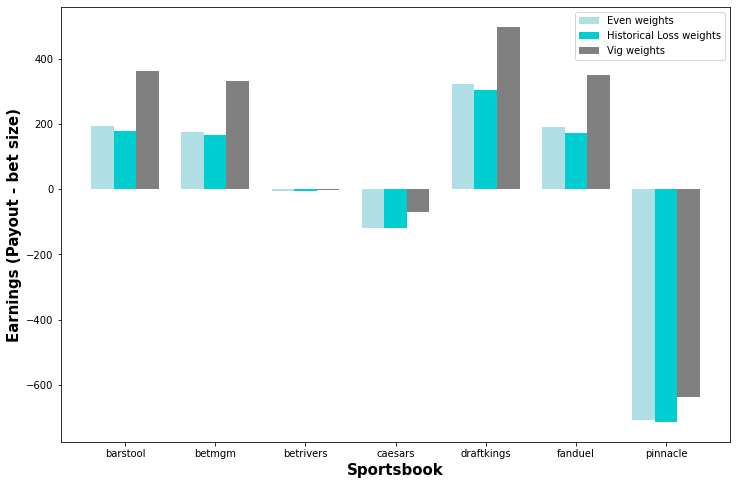

In [139]:
barwidth = 0.25
fig = plt.subplots(figsize = (12, 8))
br1 = np.arange(len(evenearnings)) 
br2 = [x + barwidth for x in br1] 
br3 = [x + barwidth for x in br2] 
plt.bar(br1, evenearnings, color ='powderblue', width = barwidth, 
         label ='Even weights') 
plt.bar(br2, lossearnings, color ='darkturquoise', width = barwidth, 
         label ='Historical Loss weights') 
plt.bar(br3, vigearnings, color ='grey', width = barwidth, 
         label ='Vig weights') 
plt.xlabel('Sportsbook', fontweight ='bold', fontsize = 15) 
plt.ylabel('Earnings (Payout - bet size)', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barwidth for r in range(len(evenearnings))], 
        ['barstool', 'betmgm', 'betrivers', 'caesars', 'draftkings', 'fanduel', 'pinnacle'])
plt.legend()
plt.show() 

Our higher payout methods weigh pinnacle more because its odd spreads are tighter and we assume pinnacle has the most information so we weigh it heavily. However, it is also bad to bet against it due to this, which is why we see such negative results from betting against pinnacle.

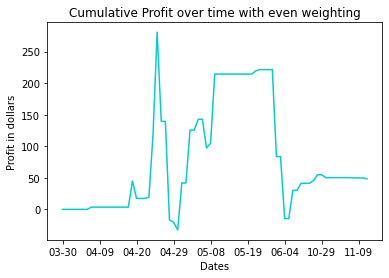

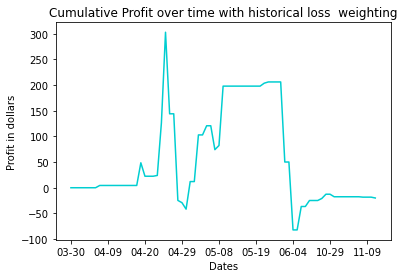

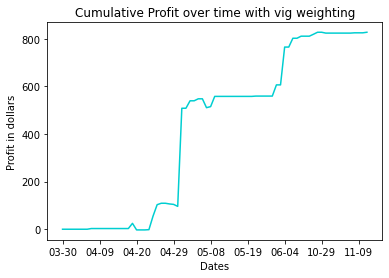

In [141]:
evendaypay = evenweight.groupby('date').sum()
evendaypay['daypay'] = evendaypay['payout'] - evendaypay['home_bet_size'] - evendaypay['away_bet_size']
lossdaypay = loss.groupby('date').sum()
lossdaypay['daypay'] = lossdaypay['payout'] - lossdaypay['home_bet_size'] - lossdaypay['away_bet_size']
vigdaypay = vig.groupby('date').sum()
vigdaypay['daypay'] = vigdaypay['payout'] - vigdaypay['home_bet_size'] - vigdaypay['away_bet_size']

evendaypay['cumpay'] = evendaypay['daypay'].cumsum()
lossdaypay ['cumpay']= lossdaypay['daypay'].cumsum()
vigdaypay['cumpay'] = vigdaypay['daypay'].cumsum()
evendaypay['cumpay'].index = evendaypay['cumpay'].index.str.slice(5,10)
lossdaypay['cumpay'].index = lossdaypay['cumpay'].index.str.slice(5,10)
vigdaypay['cumpay'].index = vigdaypay['cumpay'].index.str.slice(5,10)


plt.plot(evendaypay['cumpay'], color = 'darkturquoise')
plt.xticks(np.arange(0, len(evendaypay['cumpay']) + 1, 9))
plt.title('Cumulative Profit over time with even weighting')
plt.xlabel('Dates')
plt.ylabel('Profit in dollars')
plt.show()

plt.plot(lossdaypay['cumpay'], color = 'darkturquoise')
plt.xticks(np.arange(0, len(evendaypay['cumpay']) + 1, 9))
plt.title('Cumulative Profit over time with historical loss  weighting')
plt.xlabel('Dates')
plt.ylabel('Profit in dollars')
plt.show()

plt.plot(vigdaypay['cumpay'], color = 'darkturquoise')
plt.xticks(np.arange(0, len(evendaypay['cumpay']) + 1, 9))
plt.title('Cumulative Profit over time with vig weighting')
plt.xlabel('Dates')
plt.ylabel('Profit in dollars')
plt.show()

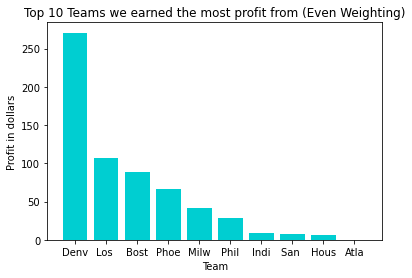

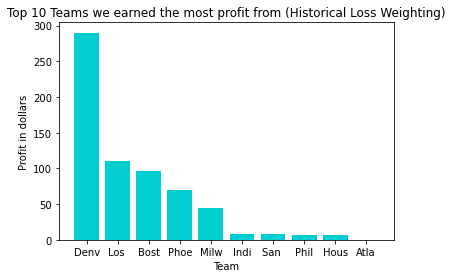

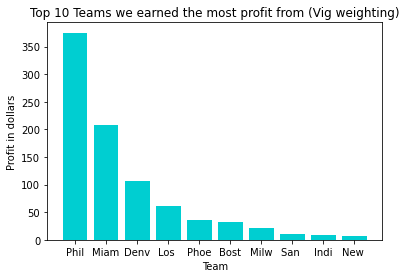

[375.18413687 207.33614772 106.28210653  61.31830493  36.26124226
  32.08686583  21.83438922   9.61116554   8.4728474    7.08871191]


In [162]:
eventeam = evenweight.groupby('winner').sum()
eventeam['earnings'] = eventeam['payout'] - eventeam['home_bet_size'] - eventeam['away_bet_size']
lossteam = loss.groupby('winner').sum()
lossteam['earnings'] = lossteam['payout'] - lossteam['home_bet_size'] - lossteam['away_bet_size']
vigteam = vig.groupby('winner').sum()
vigteam['earnings'] = vigteam['payout'] - vigteam['home_bet_size'] - vigteam['away_bet_size']



eventeamearn = eventeam.sort_values(by= 'earnings', ascending = False)['earnings']
lossteamearn = lossteam.sort_values(by= 'earnings', ascending = False)['earnings']
vigteamearn = vigteam.sort_values(by= 'earnings', ascending = False)['earnings']
eventeamearn.index = eventeamearn.index.str.slice(0, 4)
lossteamearn.index = lossteamearn.index.str.slice(0, 4)
vigteamearn.index= vigteamearn.index.str.slice(0,4)

plt.bar(list(eventeamearn.keys())[:10], eventeamearn.values[:10], width = .8, color = 'darkturquoise')
plt.title('Top 10 Teams we earned the most profit from (Even Weighting)')
plt.xlabel('Team')
plt.ylabel('Profit in dollars')
plt.show()
plt.bar(list(lossteamearn.keys())[:10], lossteamearn.values[:10], width = .8, color = 'darkturquoise')
plt.title('Top 10 Teams we earned the most profit from (Historical Loss Weighting)')
plt.xlabel('Team')
plt.ylabel('Profit in dollars')
plt.show()
plt.bar(list(vigteamearn.keys())[:10], vigteamearn.values[:10], width = .8, color = 'darkturquoise')
plt.title('Top 10 Teams we earned the most profit from (Vig weighting)')
plt.xlabel('Team')
plt.ylabel('Profit in dollars')
plt.show()

print(vigteamearn.values[:10])



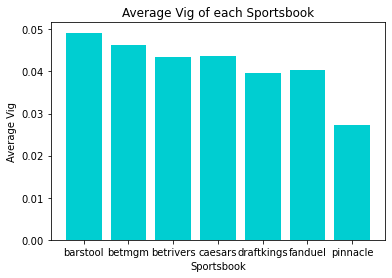

In [168]:
vigmeans = vigs.groupby('sportsbook').mean()
plt.bar(list(vigmeans.index), vigmeans.values.flatten(), width = .8, color = 'darkturquoise')
plt.title('Average Vig of each Sportsbook')
plt.xlabel('Sportsbook')
plt.ylabel('Average Vig')
plt.show()

